# Extracting a Composite Exclusion Layer

**Prerequisites:**

- Required: [GeoTIFFs to reV HDF5 Files](./02_layered_h5_tutorial.ipynb)
- Recommended: [Working with GeoTIFFs](./01_geotiff_tutorial.ipynb)

----

## Introduction

In some analysis, you might want to combine multiple layers into one composite layer to understand how much land is included or excluded based on some exclusion criteria. This is particularly useful if you have put together a `reV` supply curve aggregation configuration and would like to visualize the resulting composite exclusions.

This tutorial will take you through the process of building out this criteria and using the criteria specifications to extract a boolean mask layer.

Let's get started!

Let's start with a few common imports:

In [82]:
import matplotlib.pyplot as plt

from reVX.handlers.layered_h5 import LayeredH5
from reVX.handlers.geotiff import Geotiff
from reV.handlers.exclusions import ExclusionLayers
from reV.supply_curve.exclusions import ExclusionMaskFromDict

## Creating the Composite Mask

First let's add path definitions and take a look at the layers in the layered HDF5 file:

In [3]:
H5_PATH = "example.h5"
h5 = LayeredH5(H5_PATH)
h5.layers

['airport_heliport_setbacks',
 'latitude',
 'longitude',
 'nexrad_green_los',
 'setbacks_pipeline_reference',
 'setbacks_structure_115hh_170rd',
 'setbacks_structure_reference']

If your file does not contain these layers or you get a `FileNotFoundError`, make sure you first go through the [GeoTIFFs to reV HDF5 Files](./02_layered_h5_tutorial.ipynb) tutorial!

### Exclusion Dictionary
To extract a mask layer, we need to define a set of criteria for excluding land. This implemented via `exclusion dictionaries`. An exclusion dictionary maps layer names to instructions on _how_ that layer should be excluded. The latter is specified via another dictionary containing keywords such as `exclude_values`, `exclude_range`, `include_values`, `include_range` etc. can be specified in the exclusion dictionary to exclude/include specific values and/or range of values. More documentation on these keywords can be found [here](https://nrel.github.io/reV/_autosummary/reV.supply_curve.exclusions.LayerMask.html).

Let's create our first exclusion dictionary! We'll start with an empty Python dictionary and build it out in steps:

In [56]:
excl_dict = {}

Suppose we now want to exclude all pixels with a value of `1` in our pipeline setback exclusion layer. To do so, we add the following specification to the `excl_dict` using the layer name as the key:

In [57]:
excl_dict["setbacks_pipeline_reference"] = {"exclude_values": 1}

In this case, we only want to exclude `setbacks_pipeline_reference` layer values of `1`. However, the exclusion dictionary format is flexible enough to exclude other values from our layer, including specifying multiple exclusion values at once:

In [58]:
excl_dict["setbacks_pipeline_reference"] = {"exclude_values": [1, 2, 3]}

In practice, the two specifications above are identical since our `setbacks_pipeline_reference` layer contains only binary data. If, instead, our layer contained a range of values, we would have precise control over which pixels are ultimately excluded in our composite layer. 

If our layer contains a large range of values, we do not have to type them in one-by-one. Instead, we can use the `exclude_range` specification instead:

In [59]:
excl_dict["setbacks_structure_115hh_170rd"] = {"exclude_range": [1, 3]}



In this example, we would exclude all pixels that contain the values 1, 2, and 3. 

We won't cover all possible keyword specification in this tutorial - please refer to [the documentation](https://nrel.github.io/reV/_autosummary/reV.supply_curve.exclusions.LayerMask.html) for a list of all possible inputs.

Let's add a one more layer to our exclusion dictionary:

In [74]:
excl_dict.update(
    {"airport_heliport_setbacks": {"exclude_values": 1}}
)

Our final exclusion dictionary now looks like:

In [75]:
excl_dict

{'setbacks_pipeline_reference': {'exclude_values': [1, 2, 3]},
 'setbacks_structure_115hh_170rd': {'exclude_range': [1, 3]},
 'airport_heliport_setbacks': {'exclude_values': 1}}

We could of course create this dictionary in one go instead of building it in pieces.

### Computing the composite exclusions

Once the exclusion dictionary has been put together, we simply call the following method to create the composite exclusion mask:

In [76]:
mask_ = ExclusionMaskFromDict.run(str(H5_PATH), layers_dict=excl_dict)

<div class="alert alert-block alert-warning">
<b>WARNING:</b> The output of this method is actually an inclusion mask, where a value of 0 represents a fully excluded pixel and a value of 1 represents a fully included pixel.</div>

The run method also has `min_area` and `kernel` arguments you can use to specify the minimum contiguous area and contiguous filter method. For more information on these inputs, see the [reV documentation](https://nrel.github.io/reV/_cli/reV%20supply-curve-aggregation.html#:~:text=default%2C%20None.-,area_filter_kernel,-%7B%E2%80%9Cqueen%E2%80%9D%2C%20%E2%80%9Crook%E2%80%9D%7D%2C%20optional).

<div class="alert alert-block alert-info">
<b>Note:</b> The argument names differ slightly in the linked documentation but have identical function.</div>

To write out the composite exclusion mask layer to a file, we can use the `Geotiff` handler (we write `1 - mask_` to convert the data to an exclusion layer):

In [77]:
Geotiff.write("composite_exclusion_mask.tif", h5.profile, 1 - mask_)

We can plot the data to verify that the exclusion mask was computed correctly:

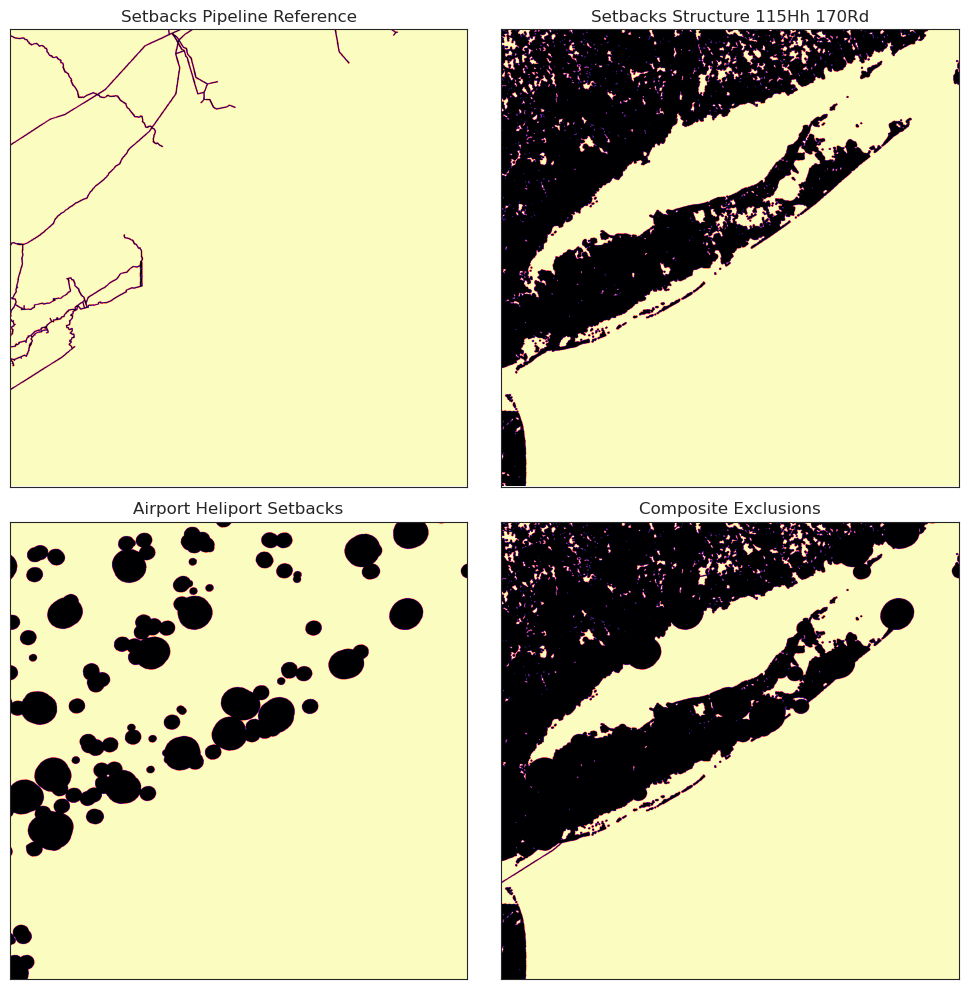

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

with ExclusionLayers(H5_PATH) as excl:
    for layer_name, ax in zip(excl_dict, axes.ravel()):
        data = excl[layer_name]
        if "airport" in layer_name:
            data[data != 1] = 0
        ax.imshow(data, cmap="magma_r")
        ax.tick_params(
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labeltop=False,
            labelleft=False,
            labelright=False
        )
        ax.set_title(layer_name.replace("_", " ").title())

ax = axes[1, 1]
with Geotiff("composite_exclusion_mask.tif") as geo:
    data = geo.values[0]
    ax.imshow(geo.values[0], cmap="magma_r")
    ax.tick_params(
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False
    )
    ax.set_title("Composite Exclusions")

fig.tight_layout()

## Composite Exclusion Layer via CLI

Alternatively, the command line can be used to create the composite exclusion layer. This approach is particularly useful if you already have a `reV` supply curve aggregation config file on hand.

First, we need to construct a JSON config file (e.g. `excl_dict.json`) that contains the exclusion dictionary:

```json
{
    "excl_dict" : {
        "setbacks_pipeline_reference": {"exclude_values": [1, 2, 3]},
        "setbacks_structure_115hh_170rd": {"exclude_range": [1, 3]},
        "airport_heliport_setbacks": {"exclude_values": 1}
    }
}
```

Then we can run the following command: 

```bash
$ reVX exclusions -h5 example.h5 mask --excl_dict_fpath excl_dict.json -o composite_exclusions.tif
```

This command also has `--min_area` and `--kernel` options. 

## Conclusion
In this tutorial, we have walked through the basic steps required to combine multiple exclusion layers into one composite exclusion layer. You should now be able to:
- Create an exclusion dictionary
- Create a corresponding composite exclusion layer 
- Write the exclusion layer to a file
- Perform all of the above tasks from the command line 
